In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=42986dfb09139bde1e7832c0b4ba50750f439b51ad1854ac532a7329d955387b
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [3]:
# Create a Spark session
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# Load the dataset
df = spark.read.csv("Mall_Customers.csv", header=True, inferSchema=True)

In [4]:
# View the data structure
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [6]:
# Selecting relevant features (Age, Annual Income, and Spending Score)
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Create feature vector
assembler = VectorAssembler(inputCols=features, outputCol='features')
df_features = assembler.transform(df)

In [7]:
# Normalize the features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

## Applying K-Means Clustering

In [8]:
# Define the KMeans algorithm with k clusters (let's assume k=5)
kmeans = KMeans(featuresCol="scaled_features", k=5, seed=1)

# Fit the model
model = kmeans.fit(df_scaled)

In [9]:
# Make predictions (adding a 'prediction' column indicating the cluster)
predictions = model.transform(df_scaled)

# Show the results
predictions.select('CustomerID', 'scaled_features', 'prediction').show(10)

+----------+--------------------+----------+
|CustomerID|     scaled_features|prediction|
+----------+--------------------+----------+
|         1|[1.36015391423519...|         0|
|         2|[1.50332801047048...|         0|
|         3|[1.43174096235284...|         1|
|         4|[1.64650210670576...|         0|
|         5|[2.21919849164690...|         0|
|         6|[1.57491505858812...|         0|
|         7|[2.50554668411747...|         1|
|         8|[1.64650210670576...|         0|
|         9|[4.58157107952909...|         1|
|        10|[2.14761144352926...|         0|
+----------+--------------------+----------+
only showing top 10 rows



In [10]:
# Count the distinct clusters (predictions)
total_clusters = predictions.select("prediction").distinct().count()
print(f"Total number of clusters: {total_clusters}")

Total number of clusters: 5


In [12]:
# Evaluate clustering by computing the Within Set Sum of Squared Errors (WSSSE)
wssse = model.summary.trainingCost
print(f"Within Set Sum of Squared Errors = {wssse}")

Within Set Sum of Squared Errors = 167.40634227469047


## Re-run the K-Means model to compare WSSSE value and find the elbow point

In [13]:
wssse_values = []

# Try different k values
for k in range(2, 10):
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=1)
    model = kmeans.fit(df_scaled)
    wssse = model.summary.trainingCost
    wssse_values.append(wssse)

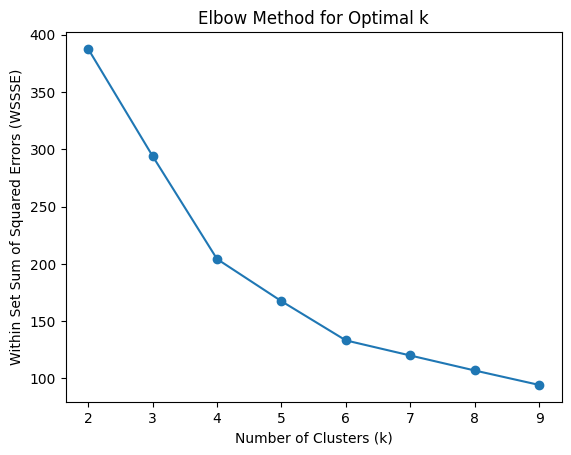

In [14]:
import matplotlib.pyplot as plt

# Plot the elbow curve
plt.plot(range(2, 10), wssse_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

The curve seems to bend around k=4 or k=5, which suggests that 4 or 5 clusters might be the optimal number for the data.

In [15]:
kmeans = KMeans(featuresCol="scaled_features", k=5, seed=1)
model = kmeans.fit(df_scaled)

# Make predictions
predictions = model.transform(df_scaled)

# Show the results
predictions.select('CustomerID', 'scaled_features', 'prediction').show(10)

+----------+--------------------+----------+
|CustomerID|     scaled_features|prediction|
+----------+--------------------+----------+
|         1|[1.36015391423519...|         0|
|         2|[1.50332801047048...|         0|
|         3|[1.43174096235284...|         1|
|         4|[1.64650210670576...|         0|
|         5|[2.21919849164690...|         0|
|         6|[1.57491505858812...|         0|
|         7|[2.50554668411747...|         1|
|         8|[1.64650210670576...|         0|
|         9|[4.58157107952909...|         1|
|        10|[2.14761144352926...|         0|
+----------+--------------------+----------+
only showing top 10 rows



In [19]:
# Export the results for visualization
export_data = predictions.select('CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'prediction').join(df.select("CustomerID", "Gender"), on="CustomerID", how="inner")
export_data.toPandas().to_csv("customer_segmentsResult.csv", index=False)